In [192]:
%reload_ext autoreload
%autoreload 2
import tensorflow as tf
import sys
import math
import numpy as np
sys.path.append('../../pytools')
import d2l
import collections
import re
import random

d2l.gpu_mem_init()

Memory growth enabled for PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'): True


In [193]:
batch_size,num_steps = 32,35
train_iter,vocab = d2l.load_data_time_machine(batch_size, num_steps)

In [194]:
tf.one_hot([0, 2], 28)

<tf.Tensor: shape=(2, 28), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)>

In [195]:
X = tf.reshape(tf.range(10), (2, 5))
tf.one_hot(tf.transpose(X), 28).shape

TensorShape([5, 2, 28])

In [196]:
def get_params(vocab_size, num_hiddens):
    num_input = num_output = vocab_size
    def normal(shape):
        return tf.random.normal(shape=shape, mean=0, stddev=0.01, dtype=tf.float32)
    W_xh = tf.Variable(normal((num_input, num_hiddens)), dtype=tf.float32)
    W_hh = tf.Variable(normal((num_hiddens, num_hiddens)), dtype=tf.float32)
    B_h = tf.Variable(tf.zeros((num_hiddens)))

    W_hq = tf.Variable(normal((num_hiddens, num_output)), dtype=tf.float32)
    B_q = tf.Variable(tf.zeros((num_output)), dtype=tf.float32)
    params = [W_xh, W_hh, B_h, W_hq, B_q]
    return params

In [197]:
def init_rnn_state(batch_size, num_hiddens):
    return (tf.zeros((batch_size, num_hiddens)),)

In [198]:
def rnn(inputs, state, params):
    W_xh, W_hh, B_h, W_hq, B_q = params
    H, = state
    outputs = []
    for X in inputs:
        X = tf.reshape(X, [-1, W_xh.shape[0]])
        H = tf.tanh(tf.matmul(X, W_xh) + tf.matmul(H, W_hh) + B_h)
        Y = tf.matmul(H, W_hq) + B_q 
        outputs.append(Y)
    return tf.concat(outputs, axis=0),(H,)


In [199]:
class RNNModelScratch:
    def __init__(self, vocab_size, num_hiddens, init_state, forward_fn, get_params):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.init_state, self.forward_fn = init_state, forward_fn
        self.trainable_variables = get_params(vocab_size, num_hiddens)
        #
    def __call__(self, X, state):
        input = tf.one_hot(tf.transpose(X), self.vocab_size)
        input = tf.cast(input, dtype=tf.float32)
        return self.forward_fn(input, state, self.trainable_variables)

    def begin_state(self, batch_size):
        return self.init_state(batch_size, self.num_hiddens)

In [200]:
# 定义tensorflow训练策略
device_name = d2l.try_gpu()._device_name
strategy = tf.distribute.OneDeviceStrategy(device_name)

num_hiddens = 512
with strategy.scope():
    net = RNNModelScratch(len(vocab), num_hiddens, init_rnn_state, rnn,
                          get_params)
state = net.begin_state(X.shape[0])
Y, new_state = net(X, state)
Y.shape, len(new_state), new_state[0].shape

(TensorShape([10, 28]), 1, TensorShape([2, 512]))

In [201]:
def predict_ch8(prefix, num_preds, net, vocab):
    state = net.begin_state(batch_size=1)
    outputs = [vocab[prefix[0]]]
    get_input = lambda : tf.reshape(tf.constant([outputs[-1]]), (1,1)).numpy()
    for y in prefix[1:]:
        _,state = net(get_input(), state)
        outputs.append(vocab[y])
    for _ in range(num_preds):
        y,state = net(get_input(), state)
        outputs.append(int(y.numpy().argmax(axis=1).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

In [202]:
predict_ch8('time traveller ', 10, net, vocab)

/tmp/ipykernel_3375068/1234017843.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  outputs.append(int(y.numpy().argmax(axis=1).reshape(1)))


'time traveller drwij drwi'

In [203]:
##TODO 将带有自定义函数的模型保存为saved_model

##fix  原书中的代码计算出的norm始终小于1.0，导致没有实际走到梯度裁剪的地方。
##fix  此处对原有的代码进行了调整
def grad_clipping(grads, theta):
    theta = tf.constant(theta, dtype=tf.float32)
    new_grads = []
    for grad in grads:
        if isinstance(grad, tf.IndexedSlices):
            new_grads.append(tf.convert_to_tensor(grad))
        else:
            new_grads.append(grad)

    norm = tf.math.sqrt(sum((tf.reduce_sum(grad**2)).numpy() for grad in new_grads))
    norm = tf.cast(norm, dtype=tf.float32)

    theta_f = 1.0
    if norm < 1.0:
        theta_f = norm + 0.0001
    else:
        theta_f = theta / norm

    for i,grad in enumerate(new_grads):
        new_grads[i] = grad * theta_f
    return new_grads

In [204]:
def train_epoch_ch8(net, train_iter, loss, optimizer, user_random_iter, vocab_size):
    state, timer = None, d2l.Timer()
    metric = d2l.Accumulator(2)  
    for X,Y in train_iter:
        if state is None or user_random_iter:
            state = net.begin_state(X.shape[0])
        with tf.GradientTape(persistent=True) as g:
            y_hat, state = net(X, state)
            y = tf.reshape(tf.transpose(Y), (-1))
            l = loss(y, y_hat)
        params = net.trainable_variables
        grads = g.gradient(l, params)
        grads = grad_clipping(grads, 1)
        optimizer.apply_gradients(zip(grads, params))
    metric.add(l * len(y),  len(y))
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()

In [205]:
#@save
def train_ch8(net, train_iter, vocab, lr, num_epochs, strategy,
              use_random_iter=False):
    """训练模型（定义见第8章）"""
    with strategy.scope():
        loss = tf.keras.losses.SparseCategoricalCrossentropy(
            from_logits=True)
        updater = tf.keras.optimizers.SGD(lr)
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity',
                            legend=['train'], xlim=[10, num_epochs])
    predict = lambda prefix: predict_ch8(prefix, 50, net, vocab)
    # 训练和预测
    for epoch in range(num_epochs):
        ppl, speed = train_epoch_ch8(net, train_iter, loss, updater,
                                     use_random_iter, len(vocab))
        if (epoch + 1) % 10 == 0:
            print(predict('time traveller'))
            animator.add(epoch + 1, [ppl])
    device = d2l.try_gpu()._device_name
    print(f'困惑度 {ppl:.1f}, {speed:.1f} 词元/秒 {str(device)}')
    print(predict('time traveller '))
    print(predict('traveller '))

困惑度 1.5, 1287.5 词元/秒 /GPU:0
time traveller hom so erove that there ar havl on all these are e
traveller for in aromy tigee hither an thereding atwryee car


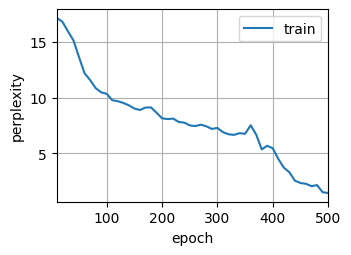

In [206]:
num_epochs, lr = 500, 1.1
train_ch8(net, train_iter, vocab, lr, num_epochs, strategy)